In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import time
import pickle

In [2]:
np.set_printoptions(precision=4)

In [3]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, cbar = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if cbar == True:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# One Fifth Ratio

In [4]:
boa = [25., 30.]
freq = [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

categories = {}

i = 0
for b in boa:
    for f in freq:
        categories[i] = str(b) + ', ' + str(f)
        i+=1

In [5]:
train_X = np.load("/Volumes/KleeFD/dataset/window_normalized/Window Size/one fifth/train_X.npy")
train_Y = np.load("/Volumes/KleeFD/dataset/window_normalized/Window Size/one fifth/train_Y.npy")

ratio = '1/5'
size = 120 * 120
rPODeach = 10


s = np.where((train_Y[:,0] == 25.) & (train_Y[:,1] == 0.3))

Data_split = [] # split the data into categories, to create the library.

i = 0


for b in boa:
    for f in freq:
        s = np.where((train_Y[:,0] == b) & (train_Y[:,1] == f))
        if s[0].shape[0] == 0:
            print(b, f)
            break
        # print(b,f, ' : category', i)
        i += 1
        Data_split.append(train_X[s])
        

Library = np.empty((size,0))

for cat in range(16):
    DataVecsTrain = np.zeros((size, len(Data_split[cat])))

    for i, d in enumerate(Data_split[cat]):
        DataVecsTrain[:,i] = d.reshape(-1)
        
    U, S, Vt = np.linalg.svd(DataVecsTrain, full_matrices = False)
    Library = np.column_stack((Library, U[:,:rPODeach]))

In [6]:
# Load Testing Data

test_X = np.load("/Volumes/KleeFD/dataset/window_normalized/Window Size/one fifth/test_X.npy")
test_Y = np.load("/Volumes/KleeFD/dataset/window_normalized/Window Size/one fifth/test_Y.npy")

true_label = np.zeros((len(test_Y), 1), dtype = '<U10')
for i in range(len(test_Y)):
    true_label[i] = (str(test_Y[i,0])+', '+ str(test_Y[i, 1]))

In [7]:
# Solve

# Record the start time
start_time = time.time()

nModesSparse = 2*8*rPODeach

answers = []

testing_number = len(test_Y) # takes too long to test for every case. testing for only 100 cases

# Make input image parameter, to solve problem without initializing problem everytime
X = cp.Parameter((size))
s = cp.Variable(nModesSparse)
objective = cp.Minimize(cp.norm(s, 1) + 100*cp.norm(Library @ s - X, 2))
prob = cp.Problem(objective)


for i in range(testing_number):
    
    X.value = test_X[i].reshape(-1)
    prob.solve(solver = cp.MOSEK, verbose = False)
    
    answers.append(s.value)
    
# Record the end time
end_time = time.time()

# Calculate the time spent
execution_time = end_time - start_time

# Print the execution time
print(f"Time spent: {execution_time} seconds")

Time spent: 1821.5811450481415 seconds


In [8]:
# print(answer)
predictions = []

for answer in answers:
    
    l2each = []
    for i in range(len(answer)):
        if i%rPODeach == 0:
            l2each.append(sum(abs(answer[i:i + rPODeach])))
    l2each = np.array(l2each)
    pred = np.argmax(l2each)
    predictions.append(categories[pred])

c_report = classification_report(true_label[:testing_number], predictions, zero_division = 0)    
print(c_report)

              precision    recall  f1-score   support

  25.0, 0.05       0.81      0.62      0.71        56
   25.0, 0.1       0.68      1.00      0.81        56
   25.0, 0.2       0.18      0.79      0.30        52
  25.0, 0.25       0.22      0.23      0.22        52
   25.0, 0.3       0.69      0.91      0.79        55
  25.0, 0.35       0.79      1.00      0.88        56
   25.0, 0.4       0.97      1.00      0.99        67
   25.0, 0.5       0.93      0.96      0.95        57
  30.0, 0.05       0.21      0.04      0.07       154
   30.0, 0.1       0.82      0.21      0.33       154
   30.0, 0.2       0.59      0.50      0.54       158
  30.0, 0.25       0.67      0.65      0.66       158
   30.0, 0.3       0.90      0.95      0.92       155
  30.0, 0.35       0.35      0.54      0.43       154
   30.0, 0.4       0.34      0.22      0.26       143
   30.0, 0.5       0.91      0.95      0.93       153

    accuracy                           0.59      1680
   macro avg       0.63   

Confusion matrix, without normalization


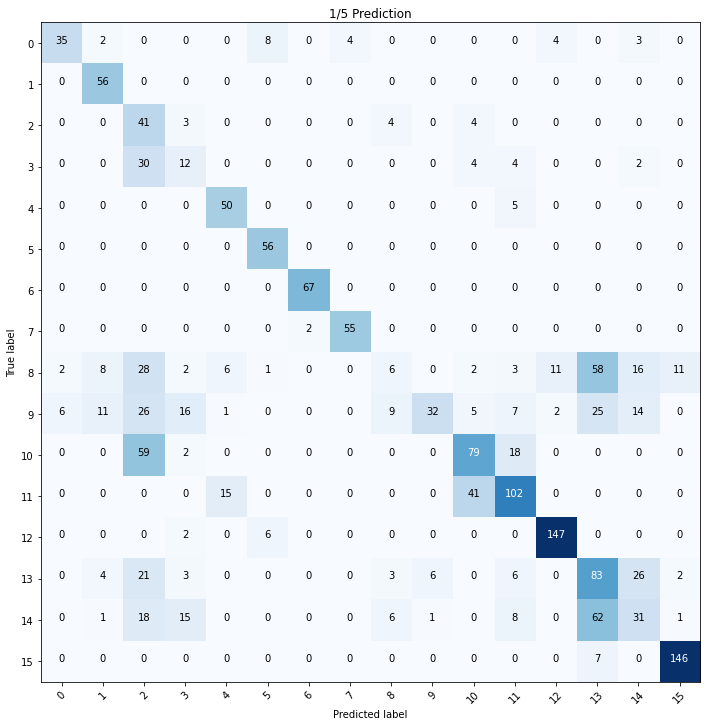

In [9]:
cnf_matrix = confusion_matrix(true_label[:testing_number], predictions)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes = categories, normalize=False,
                      title=ratio + ' Prediction')
plt.show()

In [10]:
save_path = '/Users/kunwoosmac/Library/Mobile Documents/com~apple~CloudDocs/Mac/Armour R&D/SVD reconstruction/2. one fifth/'

with open(save_path + 'pred.pickle', 'wb') as file:
    pickle.dump(predictions, file)
    
with open(save_path + 'true.pickle', 'wb') as file:
    pickle.dump(true_label, file)
    
with open(save_path + 'cnfmatrix.pickle', 'wb') as file:
    pickle.dump(cnf_matrix, file)
    
with open(save_path + 'creport.pickle', 'wb') as file:
    pickle.dump(c_report, file)
    
with open(save_path + 'time.pickle', 'wb') as file:
    pickle.dump(execution_time, file)